In [213]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
import xgboost as xgb


In [214]:

generation = pd.read_csv("datasets/Generacion_fotovoltaica.csv", sep=",")

In [215]:
# Rename columns to Prophet defaults
generation.rename(columns={'FECHA': 'ds', 'TOTAL_KWH_ENERGIA': 'y'}, inplace=True)

# Convert the 'ds' column to datetime
generation['ds'] = pd.to_datetime(generation['ds'])

# Augment the dataset with year, month, day, and hour
generation['year'] = generation['ds'].dt.year
generation['month'] = generation['ds'].dt.month
generation['day'] = generation['ds'].dt.day
generation['hour'] = generation['ds'].dt.hour

# Note: Extracting the day of the week (0-6, where 0 is Monday)
generation['weekday'] = generation['ds'].dt.weekday

generation['is_weekend'] = (generation['weekday'] >= 5).astype(int)  # 1 if Sat/Sun, else 0

#Augmented dataset
generation = generation[['ds', 'year', 'month', 'day', 'weekday', 'is_weekend', 'hour', 'y']]

# Clip negative values in 'y' to 0
generation['y'] = generation['y'].clip(lower=0)


generation

,ds,year,month,day,weekday,is_weekend,hour,y
0,2023-07-24 11:00:00,2023,7,24,0,0,11,NaN
1,2023-07-24 12:00:00,2023,7,24,0,0,12,115.66
2,2023-07-24 13:00:00,2023,7,24,0,0,13,129.98
3,2023-07-24 14:00:00,2023,7,24,0,0,14,134.35
4,2023-07-24 15:00:00,2023,7,24,0,0,15,133.90
...,...,...,...,...,...,...,...,...
9703,2024-08-31 19:00:00,2024,8,31,5,1,19,NaN
9704,2024-08-31 20:00:00,2024,8,31,5,1,20,NaN
9705,2024-08-31 21:00:00,2024,8,31,5,1,21,NaN
9706,2024-08-31 22:00:00,2024,8,31,5,1,22,NaN


In [216]:
generation.shape

(9708, 8)

In [217]:
sum(generation['y'].isnull())

1164

In [218]:
# Impute null values to 0 for the specified hours
generation.loc[generation['hour'].isin([22, 23, 0, 1, 2, 3, 4, 5, 6, 7]) & generation['y'].isnull(), 'y'] = 0

print(sum(generation['y'].isnull()))


699


In [219]:
missing_mask = generation['y'].isna()

In [220]:

# Load the dataset (assuming it's already in memory)
df = generation.copy()

# Filter for remaining NaNs after zero imputation
df_missing = df[df['y'].isna()]

In [221]:
potential_na_fix = generation[generation['y'].isna() & generation['month'].isin([10, 11, 12, 1, 2]) & generation['hour'].isin([19,20,21,8])]
len(potential_na_fix)

53

In [222]:
# Initialize the Iterative Imputer
imputer = IterativeImputer(max_iter=10, random_state=0)

# Select the columns to impute
columns_to_impute = ['y']

# Apply the imputer to the 'y' column
generation[columns_to_impute] = imputer.fit_transform(generation[columns_to_impute])

In [223]:
generation.isna().sum()

ds            0
year          0
month         0
day           0
weekday       0
is_weekend    0
hour          0
y             0
dtype: int64

In [224]:
meteo = pd.read_csv("datasets/Meteorologia.csv", sep=",")

In [225]:
generation.shape
meteo.shape

(100557, 27)

In [226]:
len(meteo["FORECAST_TIMESTAMP"].unique())

11173

In [227]:
# Group by FORECAST_TIMESTAMP and calculate the mean for all columns
meteo_averages = meteo.groupby('FORECAST_TIMESTAMP').mean()

# Display the resulting DataFrame
meteo_averages.head()

,LATITUDE,LONGITUDE,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,2shheightAboveGround_2,2theightAboveGround_2,SUNSDsurface_0,aptmpheightAboveGround_2,dlwrfsurface_0,...,spsurface_0,tccatmosphere_0,theightAboveGround_80,tmaxheightAboveGround_2,tminheightAboveGround_2,tozneatmosphereSingleLayer_0,tpsurface_0,tsurface_0,uheightAboveGround_80,vheightAboveGround_80
FORECAST_TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2023-07-24 11:00:00+00:00,40.25,-3.75,5.176383,2.306685,17.577778,0.004644,301.823414,18000.0,300.332920,320.641024,...,94006.964236,2.700000,299.178662,301.843240,293.290378,324.906396,0.0,315.466679,5.985768,2.433457
2023-07-24 12:00:00+00:00,40.25,-3.75,5.670802,2.579575,16.988889,0.004856,303.187798,21600.0,301.359812,324.429913,...,93949.704861,3.800000,300.411111,303.219008,293.290378,325.770036,0.0,317.400000,6.652786,2.790844
2023-07-24 13:00:00+00:00,40.25,-3.75,6.260587,2.442148,17.077778,0.005225,304.332392,3600.0,302.303198,352.366667,...,93885.935417,38.833333,301.517803,304.326211,303.222222,326.296606,0.0,318.032850,7.447305,2.665181
2023-07-24 14:00:00+00:00,40.25,-3.75,7.004427,2.025345,17.266667,0.005513,305.103729,7200.0,302.988475,356.926508,...,93829.203819,23.177778,302.366265,305.123018,303.222222,327.157633,0.0,317.471498,8.407716,2.233926
2023-07-24 15:00:00+00:00,40.25,-3.75,7.471493,2.054768,17.411111,0.005703,305.553950,10800.0,303.401274,360.544444,...,93770.919444,58.177778,303.032275,305.617803,303.222222,330.289266,0.0,315.935266,8.912477,2.333355


In [228]:
# Reset the index to bring FORECAST_TIMESTAMP back as a column
meteo_averages.reset_index(inplace=True)

# Convert FORECAST_TIMESTAMP to datetime if necessary
meteo_averages['FORECAST_TIMESTAMP'] = pd.to_datetime(meteo_averages['FORECAST_TIMESTAMP'])

In [229]:
meteo_filtered = meteo_averages.drop(columns=['LATITUDE', 'LONGITUDE'])
meteo_filtered['FORECAST_TIMESTAMP'] = meteo_filtered['FORECAST_TIMESTAMP'].dt.tz_localize(None)  # Remove timezone
generation['ds'] = generation['ds'].dt.tz_localize(None)  # Remove timezone from 'ds' if any

generation = generation.merge(meteo_filtered, left_on='ds', right_on='FORECAST_TIMESTAMP', how='left')

# Drop the 'FORECAST_TIMESTAMP' column after merging (if you don't need it)
generation.drop(columns=['FORECAST_TIMESTAMP'], inplace=True)

# Optionally, reorder the column 'y' back to its original position if needed
#aux = generation['y']
#generation = generation.drop(columns=['y'])
#generation['y'] = aux

# Display the first few rows of the result
generation.head()

,ds,year,month,day,weekday,is_weekend,hour,y,10uheightAboveGround_10,10vheightAboveGround_10,...,spsurface_0,tccatmosphere_0,theightAboveGround_80,tmaxheightAboveGround_2,tminheightAboveGround_2,tozneatmosphereSingleLayer_0,tpsurface_0,tsurface_0,uheightAboveGround_80,vheightAboveGround_80
0,2023-07-24 11:00:00,2023,7,24,0,0,11,24.085597,5.176383,2.306685,...,94006.964236,2.700000,299.178662,301.843240,293.290378,324.906396,0.0,315.466679,5.985768,2.433457
1,2023-07-24 12:00:00,2023,7,24,0,0,12,115.660000,5.670802,2.579575,...,93949.704861,3.800000,300.411111,303.219008,293.290378,325.770036,0.0,317.400000,6.652786,2.790844
2,2023-07-24 13:00:00,2023,7,24,0,0,13,129.980000,6.260587,2.442148,...,93885.935417,38.833333,301.517803,304.326211,303.222222,326.296606,0.0,318.032850,7.447305,2.665181
3,2023-07-24 14:00:00,2023,7,24,0,0,14,134.350000,7.004427,2.025345,...,93829.203819,23.177778,302.366265,305.123018,303.222222,327.157633,0.0,317.471498,8.407716,2.233926
4,2023-07-24 15:00:00,2023,7,24,0,0,15,133.900000,7.471493,2.054768,...,93770.919444,58.177778,303.032275,305.617803,303.222222,330.289266,0.0,315.935266,8.912477,2.333355


In [230]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

generation["hour_sin"] = np.sin(2 * np.pi * generation["hour"] / 24)
generation["hour_cos"] = np.cos(2 * np.pi * generation["hour"] / 24)
generation.drop(["hour"], axis=1, inplace=True)

In [231]:
scalers = {}
for col in generation.columns:
    if col not in ["ds"]:  # Exclude timestamp
        scalers[col] = MinMaxScaler()
        generation[col] = scalers[col].fit_transform(generation[[col]])

In [232]:
generation.shape

(9708, 33)

In [233]:
missing_columns = generation.columns[generation.isnull().any()]
print("Columns with missing values:", missing_columns)

Columns with missing values: Index([], dtype='object')


In [234]:
generation = generation.drop(columns=(missing_columns))

In [235]:
# Define the cutoff date for the train-test split
cutoff_date = '2024-07-31'
# Training data is strictly before the test period and avoids Data Leakage.
# No shuffling is done, preserving the Chronological Order.


# Split into train (before May 1st) and test (from May 1st onwards until June 1st)
train_df = generation[generation['ds'] <= cutoff_date]
test_df = generation[generation['ds'] > cutoff_date]

'''
# Drop unnecessary columns for training
X_train = train_df.drop(columns=['ds', 'y'])
X_test = test_df.drop(columns=['ds', 'y'])
# fechaHora is the timestamp and should not be a predictor


# Ensuring y_train contain only the target variable
y_train = train_df['y']
y_test = test_df['y']

# Print dataset shapes
print(f"X_Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"y_Train shape: {y_train.shape}, Test shape: {y_test.shape}")'
'''


'\n# Drop unnecessary columns for training\nX_train = train_df.drop(columns=[\'ds\', \'y\'])\nX_test = test_df.drop(columns=[\'ds\', \'y\'])\n# fechaHora is the timestamp and should not be a predictor\n\n\n# Ensuring y_train contain only the target variable\ny_train = train_df[\'y\']\ny_test = test_df[\'y\']\n\n# Print dataset shapes\nprint(f"X_Train shape: {X_train.shape}, Test shape: {X_test.shape}")\nprint(f"y_Train shape: {y_train.shape}, Test shape: {y_test.shape}")\'\n'

## LSTM Training

In [236]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [237]:
class EnergyDataset(Dataset):
    def __init__(self, data, target_col="y", seq_length=24):
        self.data = data
        self.target_col = target_col
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        X = self.data.iloc[index:index + self.seq_length].drop(["ds", self.target_col], axis=1).values
        y = self.data.iloc[index + self.seq_length][self.target_col]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [238]:
len(generation)

9708

In [239]:
seq_length = 24  # Use past 6 hours to predict the next value
train_dataset = EnergyDataset(train_df, seq_length=seq_length)
test_dataset = EnergyDataset(test_df, seq_length=seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)  # No shuffling for time series
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [240]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Use the last time step output

# Initialize model
input_size = generation.shape[1] - 2  # Exclude "ds" and "y"
model = LSTMModel(input_size)

In [241]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.5f}")

Epoch 1/20, Loss: 0.02825
Epoch 2/20, Loss: 0.02099
Epoch 3/20, Loss: 0.01976
Epoch 4/20, Loss: 0.01868
Epoch 5/20, Loss: 0.01794
Epoch 6/20, Loss: 0.01744
Epoch 7/20, Loss: 0.01710
Epoch 8/20, Loss: 0.01685
Epoch 9/20, Loss: 0.01665
Epoch 10/20, Loss: 0.01645
Epoch 11/20, Loss: 0.01626
Epoch 12/20, Loss: 0.01614
Epoch 13/20, Loss: 0.01597
Epoch 14/20, Loss: 0.01588
Epoch 15/20, Loss: 0.01574
Epoch 16/20, Loss: 0.01560
Epoch 17/20, Loss: 0.01545
Epoch 18/20, Loss: 0.01539
Epoch 19/20, Loss: 0.01530
Epoch 20/20, Loss: 0.01515


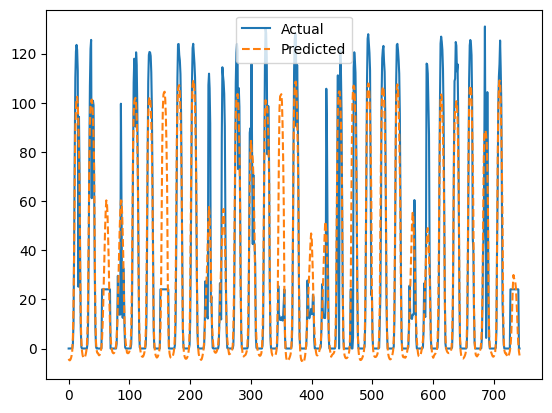

In [242]:
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch).squeeze()
        predictions.extend(y_pred.tolist())
        actuals.extend(y_batch.tolist())

# Convert back from normalized scale
actuals = scalers["y"].inverse_transform(np.array(actuals).reshape(-1, 1))
predictions = scalers["y"].inverse_transform(np.array(predictions).reshape(-1, 1))

# Plot results
import matplotlib.pyplot as plt

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted", linestyle="dashed")
plt.legend()
plt.show()

In [243]:
aux = generation.iloc[-24:].drop(["ds", "y"], axis=1).values
last_seq = torch.tensor(aux, dtype=torch.float32).unsqueeze(0)
len(last_seq)

1

In [248]:
def forecast_next_month(model, df, seq_length, steps=24*30):
    model.eval()
    df = df.drop(["ds"], axis=1)
    last_seq = df.iloc[-seq_length:].values
    last_seq = torch.tensor(last_seq, dtype=torch.float32).unsqueeze(0)

    future_preds = []
    for _ in range(steps):
        with torch.no_grad():
            pred = model(last_seq).item()
            future_preds.append(pred)

        # Update sequence for next prediction
        new_row = last_seq[:, 1:, :].clone()  # Shift left
        new_features = torch.tensor(df.iloc[-1].values, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        last_seq = torch.cat((new_row, new_features), dim=1)

    # Convert back from normalized scale
    future_preds = scalers["y"].inverse_transform(np.array(predictions).reshape(-1, 1))

    return future_preds

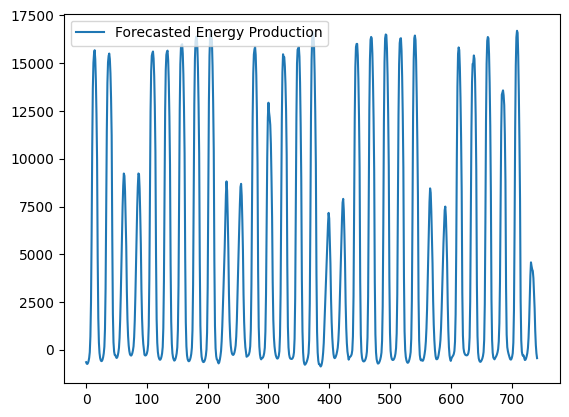

array([[-6.45636155e+02],
       [-7.25051853e+02],
       [-7.35164859e+02],
       [-6.85350287e+02],
       [-5.82194698e+02],
       [-4.16985821e+02],
       [-1.16244938e+02],
       [ 7.01451582e+02],
       [ 2.49669734e+03],
       [ 5.95198181e+03],
       [ 1.05719147e+04],
       [ 1.36807321e+04],
       [ 1.50212769e+04],
       [ 1.55054865e+04],
       [ 1.56785423e+04],
       [ 1.52112002e+04],
       [ 1.40978418e+04],
       [ 1.23420987e+04],
       [ 9.94023874e+03],
       [ 4.82074302e+03],
       [ 1.65821947e+03],
       [ 3.79780307e+02],
       [-1.64273076e+02],
       [-4.22824369e+02],
       [-5.40189755e+02],
       [-5.89686343e+02],
       [-5.79507367e+02],
       [-5.07232171e+02],
       [-3.77124739e+02],
       [-1.79566671e+02],
       [ 1.65364204e+02],
       [ 1.09021712e+03],
       [ 3.21795747e+03],
       [ 7.10786278e+03],
       [ 1.14359527e+04],
       [ 1.39629105e+04],
       [ 1.50474430e+04],
       [ 1.53833737e+04],
       [ 1.5

In [ ]:

future_predictions = forecast_next_month(model, generation, seq_length)

# Plot future predictions
plt.plot(future_predictions, label="Forecasted Energy Production")
plt.legend()
plt.show()
future_predictions


Please review to see if I fucked up or something because these results CANNOT be right

# From here under it's for generating the predicitons.

In [105]:
generation.head()

,ds,year,month,day,weekday,is_weekend,y,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,...,theightAboveGround_80,tmaxheightAboveGround_2,tminheightAboveGround_2,tozneatmosphereSingleLayer_0,tpsurface_0,tsurface_0,uheightAboveGround_80,vheightAboveGround_80,hour_sin,hour_cos
0,2023-07-24 11:00:00,-1.232719,0.109775,0.900081,-1.501324,-0.630108,0.000000,1.183854,0.772389,-1.471947,...,1.002647,1.037437,0.449564,0.089303,-0.191116,1.860380,0.935656,0.582595,0.367174,-1.365587
1,2023-07-24 12:00:00,-1.232719,0.109775,0.900081,-1.501324,-0.630108,2.400297,1.335047,0.885284,-1.498208,...,1.148243,1.187551,0.449564,0.108972,-0.191116,2.018891,1.085097,0.691769,0.001142,-1.413774
2,2023-07-24 13:00:00,-1.232719,0.109775,0.900081,-1.501324,-0.630108,2.775645,1.515403,0.828430,-1.494244,...,1.278983,1.308361,1.637624,0.120964,-0.191116,2.070778,1.263104,0.653382,-0.364891,-1.365587
3,2023-07-24 14:00:00,-1.232719,0.109775,0.900081,-1.501324,-0.630108,2.890189,1.742869,0.655998,-1.485821,...,1.379217,1.395303,1.637624,0.140574,-0.191116,2.024753,1.478278,0.521642,-0.705979,-1.224309
4,2023-07-24 15:00:00,-1.232719,0.109775,0.900081,-1.501324,-0.630108,2.878394,1.885697,0.668171,-1.479379,...,1.457896,1.449290,1.637624,0.211895,-0.191116,1.898799,1.591366,0.552016,-0.998878,-0.999569


In [100]:
meteo.head()

,FORECAST_TIMESTAMP,LATITUDE,LONGITUDE,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,2shheightAboveGround_2,2theightAboveGround_2,SUNSDsurface_0,aptmpheightAboveGround_2,...,spsurface_0,tccatmosphere_0,theightAboveGround_80,tmaxheightAboveGround_2,tminheightAboveGround_2,tozneatmosphereSingleLayer_0,tpsurface_0,tsurface_0,uheightAboveGround_80,vheightAboveGround_80
0,2023-07-24 11:00:00+00:00,40.0,-4.0,6.989717,1.524463,19.6,0.005070,301.667859,18000.0,300.244031,...,95095.853125,0.8,298.878662,301.632129,291.701489,324.006396,0.0,316.100012,7.979102,1.763457
1,2023-07-24 12:00:00+00:00,40.0,-4.0,7.526357,1.301797,18.4,0.005260,303.365576,21600.0,301.470923,...,95033.793750,1.7,300.500000,303.363452,291.701489,325.803369,0.0,318.700000,8.801675,1.623066
2,2023-07-24 13:00:00+00:00,40.0,-4.0,8.506143,1.294370,18.2,0.005665,304.854614,3600.0,302.703198,...,94955.268750,8.8,301.995581,304.815100,303.400000,326.096606,0.0,319.277295,9.977305,1.662959
3,2023-07-24 14:00:00+00:00,40.0,-4.0,9.392205,1.283123,17.4,0.005709,305.681506,7200.0,303.544031,...,94899.959375,5.0,302.944043,305.689685,303.400000,326.790967,0.0,318.515942,11.152161,1.711703
4,2023-07-24 15:00:00+00:00,40.0,-4.0,10.167048,1.555879,18.3,0.006080,305.976172,10800.0,303.834607,...,94838.475000,35.8,303.432275,305.995581,303.400000,329.955933,0.0,316.435266,12.256921,2.011133


In [179]:
cutoff_date = '2024-09-01'
cutoff_date1 = '2024-10-01'
aux = meteo[meteo['FORECAST_TIMESTAMP'] > cutoff_date]
aux = aux[aux['FORECAST_TIMESTAMP'] < cutoff_date1]

In [180]:
aux.shape

(6480, 27)

In [181]:
aux.head()

,FORECAST_TIMESTAMP,LATITUDE,LONGITUDE,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,2shheightAboveGround_2,2theightAboveGround_2,SUNSDsurface_0,aptmpheightAboveGround_2,...,spsurface_0,tccatmosphere_0,theightAboveGround_80,tmaxheightAboveGround_2,tminheightAboveGround_2,tozneatmosphereSingleLayer_0,tpsurface_0,tsurface_0,uheightAboveGround_80,vheightAboveGround_80
9709,2024-09-01 00:00:00+00:00,40.0,-4.0,-2.877146,0.212925,57.3,0.011819,297.886133,2700.0,297.912183,...,95107.828125,100.0,298.633398,301.890186,297.863379,298.993127,0.1875,296.336621,-4.166997,1.909695
9710,2024-09-01 01:00:00+00:00,40.0,-4.0,-1.166338,-1.198650,68.9,0.012476,295.812207,0.0,295.858582,...,95137.556250,100.0,296.192090,296.548828,295.770532,299.731348,0.3750,295.900000,-2.364570,-1.148599
9711,2024-09-01 02:00:00+00:00,40.0,-4.0,-1.016116,-1.328894,73.1,0.012697,295.068311,0.0,295.073181,...,95132.550000,100.0,295.346641,296.580518,295.102124,298.660120,0.8125,295.150977,-2.289639,-1.448096
9712,2024-09-01 03:00:00+00:00,40.0,-4.0,-0.910071,-1.390093,75.1,0.012949,294.963379,0.0,294.993628,...,95090.556250,56.9,294.881113,296.607251,294.602124,297.191321,1.1250,294.831726,-1.784592,-1.476138
9713,2024-09-01 04:00:00+00:00,40.0,-4.0,-0.045088,-1.112429,75.8,0.012999,294.828052,0.0,294.854468,...,95101.356250,86.1,294.764355,296.552808,294.602124,296.800269,1.1250,294.412170,-0.423140,-1.120215


In [182]:
testdf = aux.groupby('FORECAST_TIMESTAMP').mean()

testdf.head()

,LATITUDE,LONGITUDE,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,2shheightAboveGround_2,2theightAboveGround_2,SUNSDsurface_0,aptmpheightAboveGround_2,dlwrfsurface_0,...,spsurface_0,tccatmosphere_0,theightAboveGround_80,tmaxheightAboveGround_2,tminheightAboveGround_2,tozneatmosphereSingleLayer_0,tpsurface_0,tsurface_0,uheightAboveGround_80,vheightAboveGround_80
FORECAST_TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2024-09-01 00:00:00+00:00,40.25,-3.75,-2.767146,1.861814,61.322222,0.011785,296.608355,2591.666667,296.623294,384.755627,...,94125.605903,100.000000,296.471176,301.101297,296.352268,300.937572,1.076389,296.392177,-4.056997,3.355250
2024-09-01 01:00:00+00:00,40.25,-3.75,-2.001893,-0.224205,71.866667,0.012492,294.967763,0.000000,294.980804,370.518934,...,94125.645139,100.000000,294.818757,295.659939,294.837199,301.242459,0.430556,295.244444,-3.281237,0.193624
2024-09-01 02:00:00+00:00,40.25,-3.75,-2.005005,0.027773,74.811111,0.012621,294.446088,0.000000,294.450959,368.318983,...,94119.572222,99.477778,294.251085,295.669406,294.324346,299.637897,1.006944,294.762088,-3.257416,0.588571
2024-09-01 03:00:00+00:00,40.25,-3.75,-2.177849,-0.483426,75.255556,0.012733,294.507823,0.000000,294.493628,366.544444,...,94076.511806,85.600000,294.110002,295.729473,294.079902,298.935765,1.215278,294.465059,-3.153481,-0.009471
2024-09-01 04:00:00+00:00,40.25,-3.75,-1.949532,-0.743540,75.288889,0.012692,294.428052,0.000000,294.432246,364.985948,...,94068.645139,67.788889,294.062133,295.697252,294.024346,298.833602,1.222222,294.134393,-2.806473,-0.481326


In [183]:
testdf.reset_index(inplace=True)

# Convert FORECAST_TIMESTAMP to datetime if necessary
testdf['FORECAST_TIMESTAMP'] = pd.to_datetime(testdf['FORECAST_TIMESTAMP'])
testdf.drop(columns=['LATITUDE', 'LONGITUDE'], inplace=True)

In [184]:
future_dates = pd.date_range(start='2024-09-01 00:00:00', end='2024-09-30 23:00:00', freq='h')

# Create an empty DataFrame for predictions
future_df = pd.DataFrame({'ds': future_dates})

# Convert Timestamp Features
future_df['hour'] = future_df['ds'].dt.hour
future_df['year'] = future_df['ds'].dt.year
future_df['month'] = future_df['ds'].dt.month
future_df['day'] = future_df['ds'].dt.day
future_df['weekday'] = future_df['ds'].dt.weekday
future_df['is_weekend'] = (future_df['weekday'] >= 5).astype(int)

In [185]:
testdf['FORECAST_TIMESTAMP'] = testdf['FORECAST_TIMESTAMP'].dt.tz_localize(None)  # Remove timezone
future_df['ds'] = future_df['ds'].dt.tz_localize(None)  # Remove timezone from 'ds' if any

future_df = future_df.merge(testdf, left_on='ds', right_on='FORECAST_TIMESTAMP', how='left')
future_df.drop(columns=['FORECAST_TIMESTAMP'], inplace=True)

In [186]:
# Apply Cyclical Encoding
future_df['hour_sin'] = np.sin(2 * np.pi * future_df['hour'] / 24)
future_df['hour_cos'] = np.cos(2 * np.pi * future_df['hour'] / 24)
future_df.drop(["hour"], axis=1, inplace=True)

In [ ]:
scalers1 = {}
for col in future_df.columns:
    if col not in ["ds"]:  # Exclude timestamp
        scalers[col] = MinMaxScaler()
        future_df[col] = scalers[col].fit_transform(future_df[[col]])

In [199]:
future_df

,ds,year,month,day,weekday,is_weekend,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,2shheightAboveGround_2,...,theightAboveGround_80,tmaxheightAboveGround_2,tminheightAboveGround_2,tozneatmosphereSingleLayer_0,tpsurface_0,tsurface_0,uheightAboveGround_80,vheightAboveGround_80,hour_sin,hour_cos
0,2024-09-01 00:00:00,0.0,0.0,0.0,1.0,1.0,0.198802,0.688282,0.680744,0.907418,...,0.660364,0.827572,0.664575,0.220704,0.181499,0.405552,0.200066,0.741970,0.500000,1.000000
1,2024-09-01 01:00:00,0.0,0.0,0.0,1.0,1.0,0.244571,0.542835,0.817527,0.976431,...,0.574766,0.562492,0.585558,0.226509,0.072600,0.371919,0.234813,0.568919,0.629410,0.982963
2,2024-09-01 02:00:00,0.0,0.0,0.0,1.0,1.0,0.244385,0.560404,0.855722,0.989027,...,0.545360,0.562954,0.558811,0.195960,0.169789,0.357784,0.235880,0.590536,0.750000,0.933013
3,2024-09-01 03:00:00,0.0,0.0,0.0,1.0,1.0,0.234047,0.524761,0.861487,1.000000,...,0.538052,0.565880,0.546062,0.182592,0.204918,0.349080,0.240535,0.557802,0.853553,0.853553
4,2024-09-01 04:00:00,0.0,0.0,0.0,1.0,1.0,0.247702,0.506624,0.861920,0.995969,...,0.535572,0.564310,0.543165,0.180647,0.206089,0.339391,0.256078,0.531976,0.933013,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,2024-09-30 19:00:00,0.0,0.0,1.0,0.0,0.0,0.389984,0.620306,0.199193,0.187031,...,0.732975,0.616439,0.638176,0.093175,0.000000,0.313446,0.415444,0.632412,0.017037,0.629410
716,2024-09-30 20:00:00,0.0,0.0,1.0,0.0,0.0,0.383768,0.610923,0.214471,0.189216,...,0.715961,0.616439,0.601581,0.129316,0.000000,0.290414,0.410704,0.619119,0.066987,0.750000
717,2024-09-30 21:00:00,0.0,0.0,1.0,0.0,0.0,0.388930,0.613727,0.220957,0.183335,...,0.699674,0.616439,0.573767,0.171971,0.000000,0.270667,0.412213,0.618358,0.146447,0.853553
718,2024-09-30 22:00:00,0.0,0.0,1.0,0.0,0.0,0.399340,0.601335,0.227443,0.178984,...,0.679050,0.616439,0.546326,0.174636,0.000000,0.250794,0.420268,0.608687,0.250000,0.933013


In [200]:
generation.head()

,ds,year,month,day,weekday,is_weekend,y,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,...,theightAboveGround_80,tmaxheightAboveGround_2,tminheightAboveGround_2,tozneatmosphereSingleLayer_0,tpsurface_0,tsurface_0,uheightAboveGround_80,vheightAboveGround_80,hour_sin,hour_cos
0,2023-07-24 11:00:00,0.0,0.545455,0.766667,0.0,0.0,0.000000,0.590779,0.527927,0.116773,...,0.657198,0.695570,0.531071,0.307271,0.0,0.771976,0.571877,0.491213,0.629410,0.017037
1,2023-07-24 12:00:00,0.0,0.545455,0.766667,0.0,0.0,2.400297,0.609859,0.539032,0.110265,...,0.689380,0.729378,0.531071,0.310399,0.0,0.806291,0.591008,0.501957,0.500000,0.000000
2,2023-07-24 13:00:00,0.0,0.545455,0.766667,0.0,0.0,2.775645,0.632620,0.533440,0.111248,...,0.718279,0.756586,0.795906,0.312307,0.0,0.817523,0.613795,0.498179,0.370590,0.017037
3,2023-07-24 14:00:00,0.0,0.545455,0.766667,0.0,0.0,2.890189,0.661326,0.516478,0.113335,...,0.740434,0.776167,0.795906,0.315425,0.0,0.807560,0.641340,0.485215,0.250000,0.066987
4,2023-07-24 15:00:00,0.0,0.545455,0.766667,0.0,0.0,2.878394,0.679351,0.517676,0.114931,...,0.757825,0.788325,0.795906,0.326768,0.0,0.780293,0.655817,0.488204,0.146447,0.146447


In [250]:
def predict_future_values(model, future_df, seq_length):
    model.eval()
    future_df = future_df.drop(["ds"], axis=1)  # Drop the timestamp column
    last_seq = future_df.iloc[-seq_length:].values  # Get the last sequence
    last_seq = torch.tensor(last_seq, dtype=torch.float32).unsqueeze(0)  # Convert to tensor and add batch dimension

    predictions = []
    for _ in range(len(future_df)):
        with torch.no_grad():
            pred = model(last_seq).item()  # Predict the next value
            predictions.append(pred)

        # Update the sequence for the next prediction
        new_row = last_seq[:, 1:, :].clone()  # Shift left
        new_features = torch.tensor(future_df.iloc[_].values, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        last_seq = torch.cat((new_row, new_features), dim=1)

    # Convert predictions back from normalized scale
    predictions = np.array(predictions).reshape(-1, 1)

    predictions_original_scale = scalers["y"].inverse_transform(np.array(predictions).reshape(-1, 1))

    return predictions_original_scale

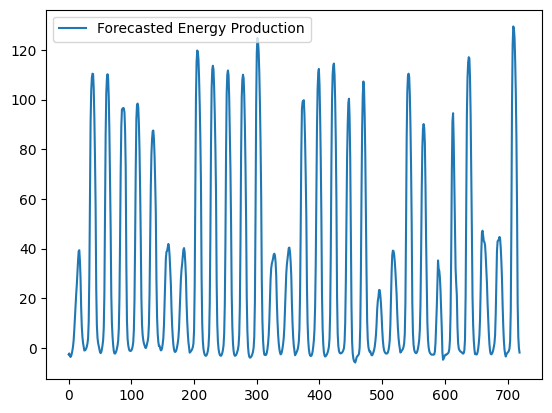

array([[-2.59794172e+00],
       [-2.18542269e+00],
       [-3.16242550e+00],
       [-3.60017278e+00],
       [-3.19289462e+00],
       [-2.24778631e+00],
       [-9.90314804e-01],
       [ 6.26090233e-01],
       [ 3.18567644e+00],
       [ 7.24705956e+00],
       [ 1.21227025e+01],
       [ 1.72042082e+01],
       [ 2.15416310e+01],
       [ 2.53936279e+01],
       [ 3.02131128e+01],
       [ 3.50904480e+01],
       [ 3.89526256e+01],
       [ 3.93783768e+01],
       [ 3.50113902e+01],
       [ 2.79057065e+01],
       [ 1.59621400e+01],
       [ 8.58324448e+00],
       [ 4.40918036e+00],
       [ 1.99021278e+00],
       [ 5.43716421e-01],
       [-9.93699248e-01],
       [-9.57441908e-01],
       [-6.79516101e-01],
       [-1.88979241e-01],
       [ 5.81989831e-01],
       [ 1.78553374e+00],
       [ 3.96990962e+00],
       [ 1.06616695e+01],
       [ 2.91532504e+01],
       [ 6.27564017e+01],
       [ 9.10258743e+01],
       [ 1.03595581e+02],
       [ 1.08751805e+02],
       [ 1.1

In [251]:
future_predictions = predict_future_values(model, future_df, seq_length)

# Plot future predictions
plt.plot(future_predictions, label="Forecasted Energy Production")
plt.legend()
plt.show()
future_predictions


In [ ]:
submission_df = pd.DataFrame(columns=['ds', 'Energia'])
submission_df['ds'] = future_df["ds"]
submission_df['Energia'] = future_predictions
submission_df.head()


,ds,Energia
0,2024-09-01 00:00:00,-2.597942
1,2024-09-01 01:00:00,-2.185423
2,2024-09-01 02:00:00,-3.162425
3,2024-09-01 03:00:00,-3.600173
4,2024-09-01 04:00:00,-3.192895


In [259]:
submission_filename = 'Challenge1_GroupX.csv'  # Replace 'GroupX' with your team name if needed

#print(f"✅ Submission file saved as '{submission_filename}'")
pd.options.display.float_format = "{:.6f}".format


# Clip the values of 'Energia' column lower than 0.5 to 0
submission_df['Energia'] = submission_df['Energia'].apply(lambda x: 0 if x < 0.5 else x)
submission_df.to_csv(submission_filename, index=False, sep=";", decimal=",")
submission_df.head(20)

,ds,Energia
0,2024-09-01 00:00:00,0.000000
1,2024-09-01 01:00:00,0.000000
2,2024-09-01 02:00:00,0.000000
3,2024-09-01 03:00:00,0.000000
4,2024-09-01 04:00:00,0.000000
5,2024-09-01 05:00:00,0.000000
6,2024-09-01 06:00:00,0.000000
7,2024-09-01 07:00:00,0.626090
8,2024-09-01 08:00:00,3.185676
9,2024-09-01 09:00:00,7.247060


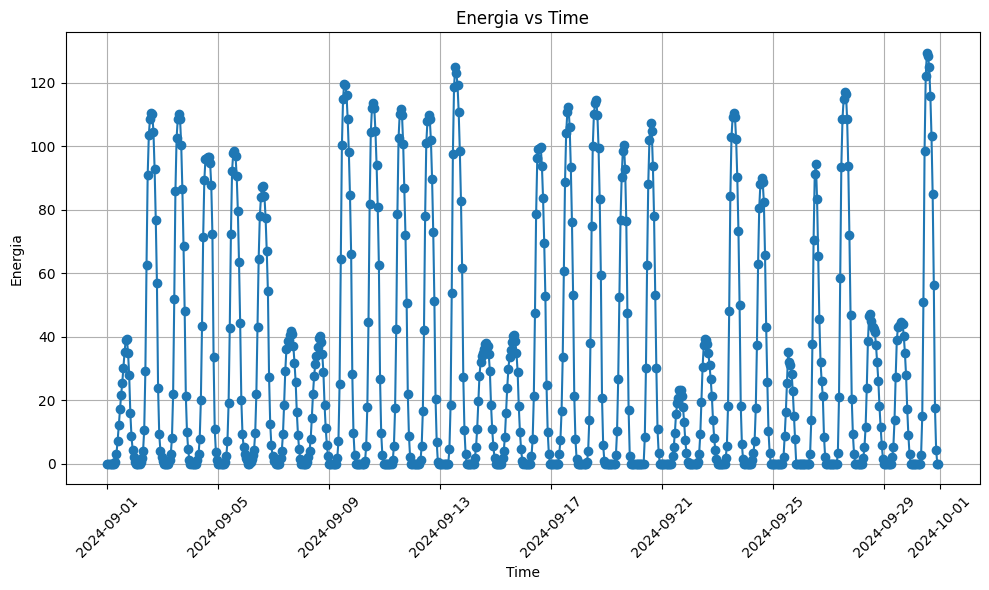

In [256]:
import matplotlib.pyplot as plt

# Plot the values of Energia against time
plt.figure(figsize=(10, 6))
plt.plot(submission_df['ds'], submission_df['Energia'], marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Energia')
plt.title('Energia vs Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
